In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import scipy.misc
import glob

In [10]:
def getCameraCallibrationResults(img, nx = 9, ny = 6):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    objPoints = []
    imgPoints = []
    
    objPointsDetected = np.zeros((nx * ny, 3), np.float32)
    objPointsDetected[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        objPoints.append(objPointsDetected)
        imgPoints.append(corners)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
        return  ret, mtx, dist, rvecs, tvecs
    else:
        return (None,None,None,None,None)

Text(0.5,1,'Undistorted Image')

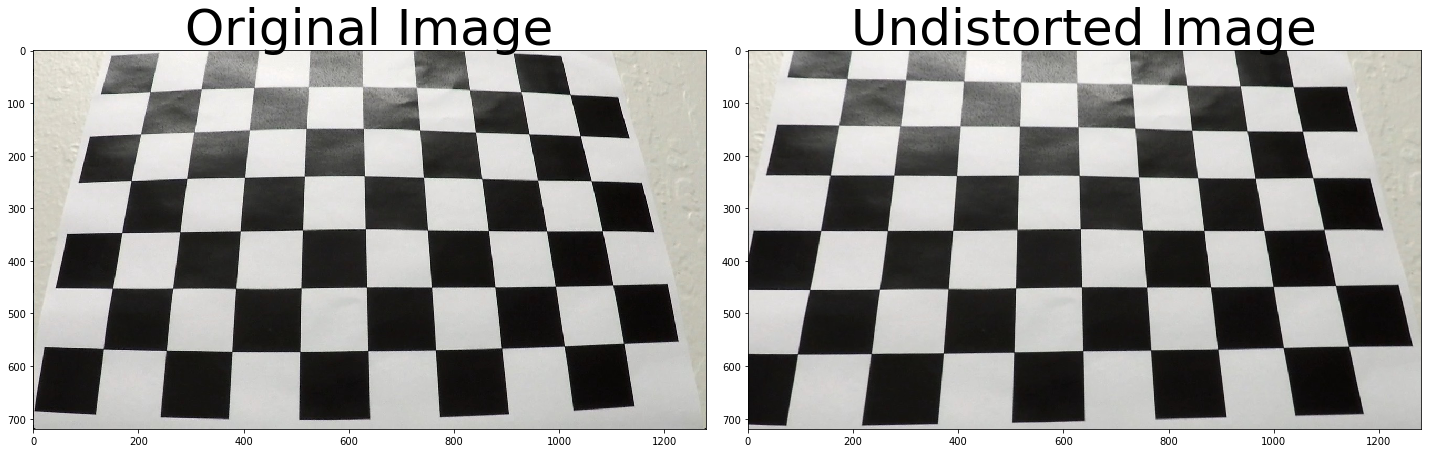

In [11]:
path = "camera_cal/calibration3.jpg"
chessImage = mpimg.imread(path)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(chessImage)
ax1.set_title('Original Image', fontsize=50)
ret, cameraMatrix, distortionCoefficients, rvecs, tvecs = getCameraCallibrationResults(chessImage)
undistort = cv2.undistort(chessImage, cameraMatrix, distortionCoefficients, None, cameraMatrix)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)

In [16]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

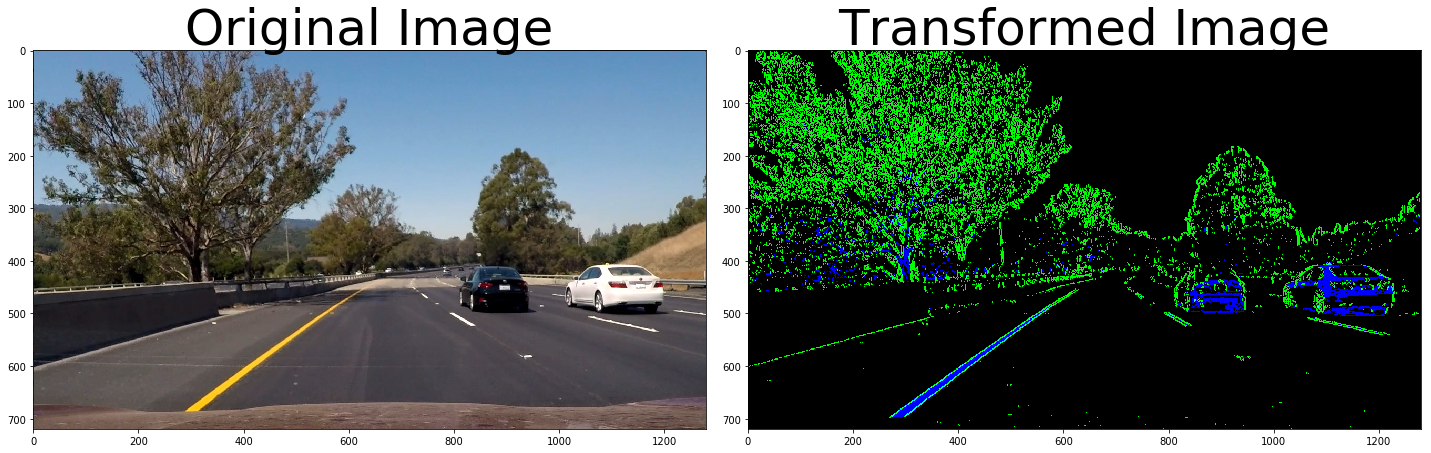

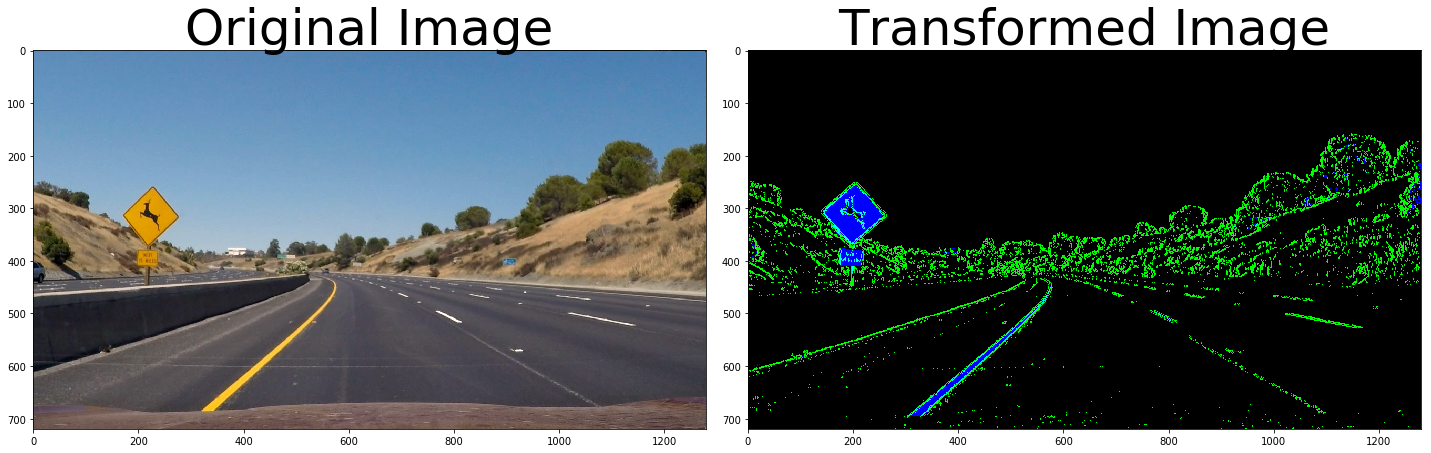

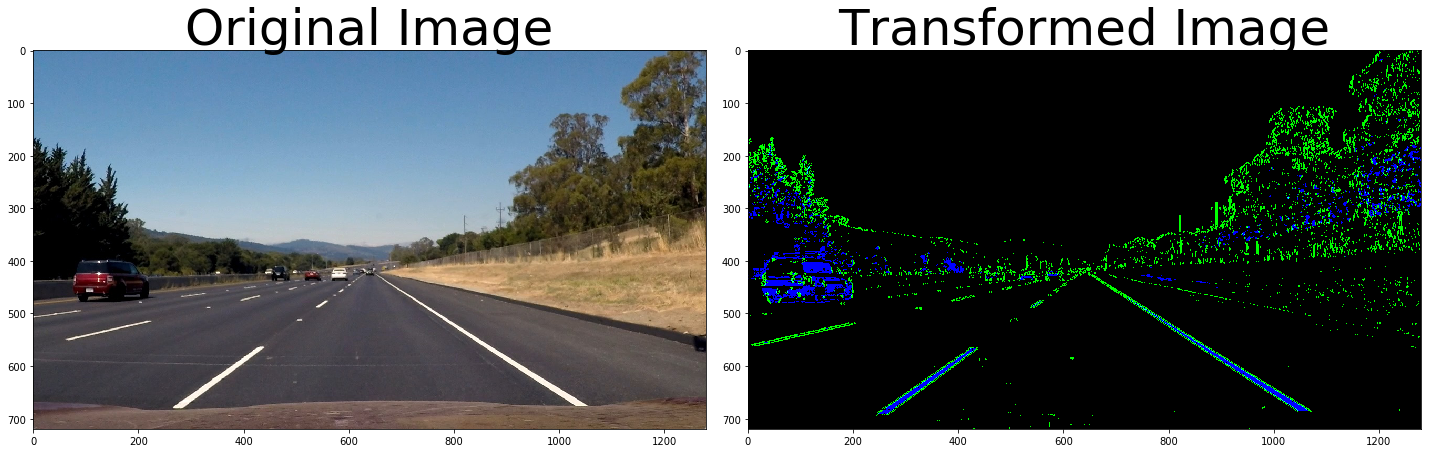

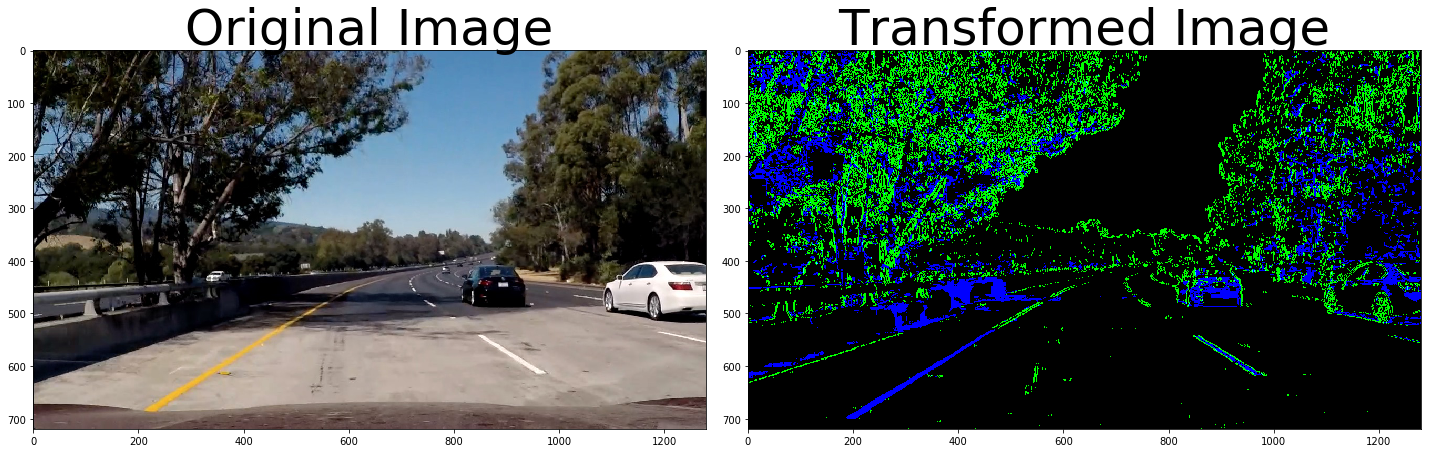

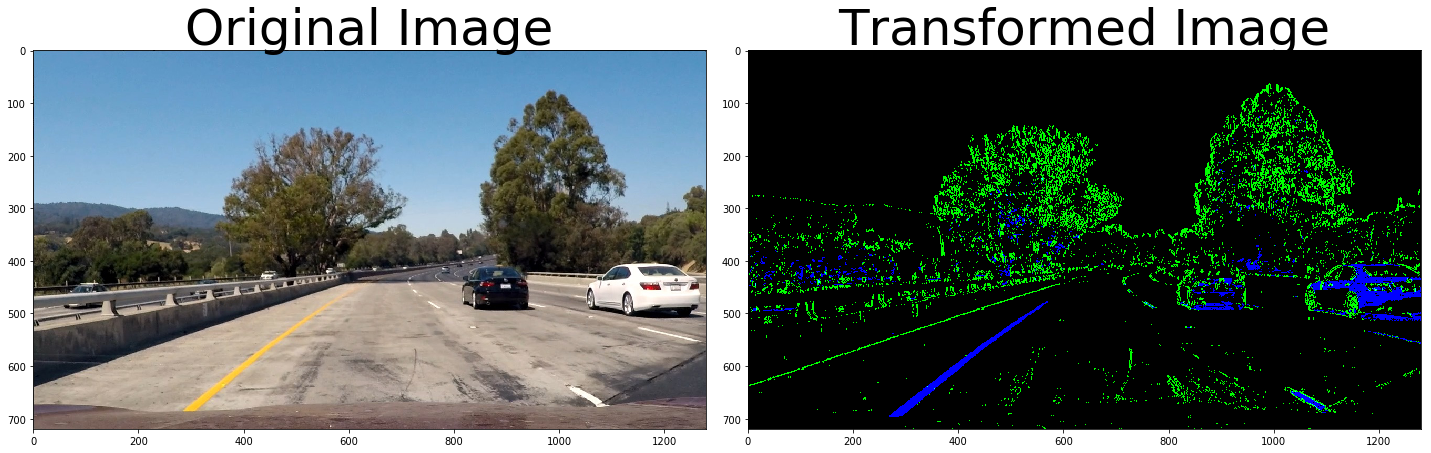

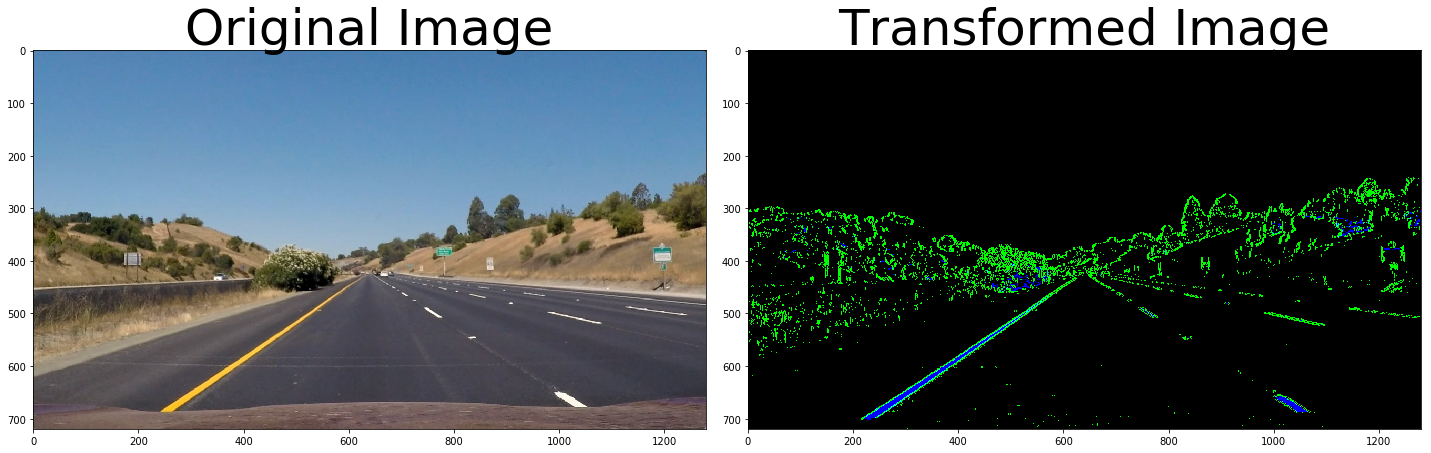

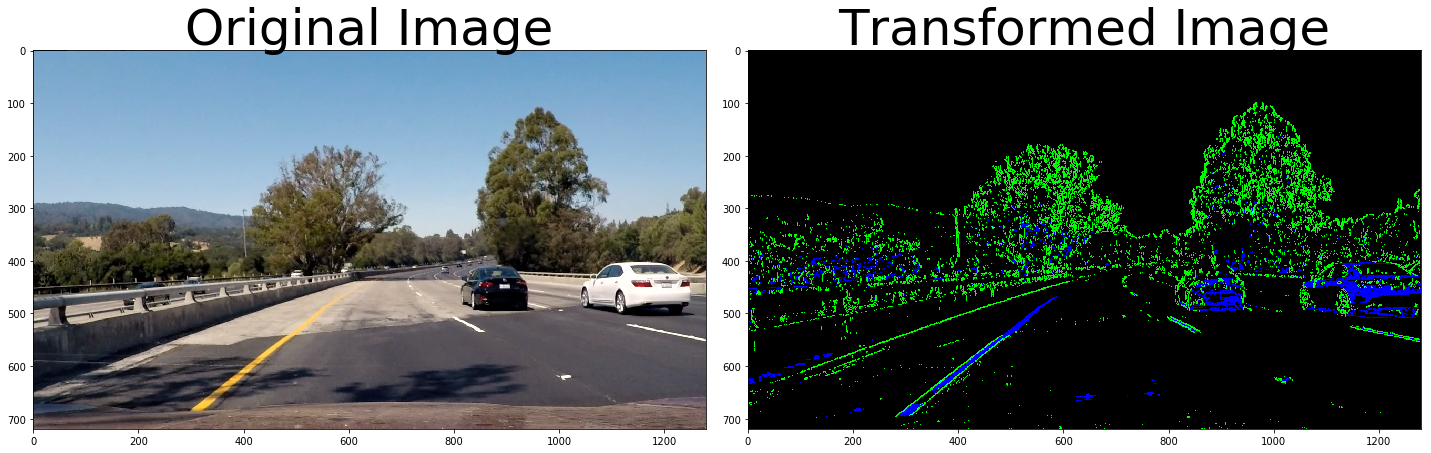

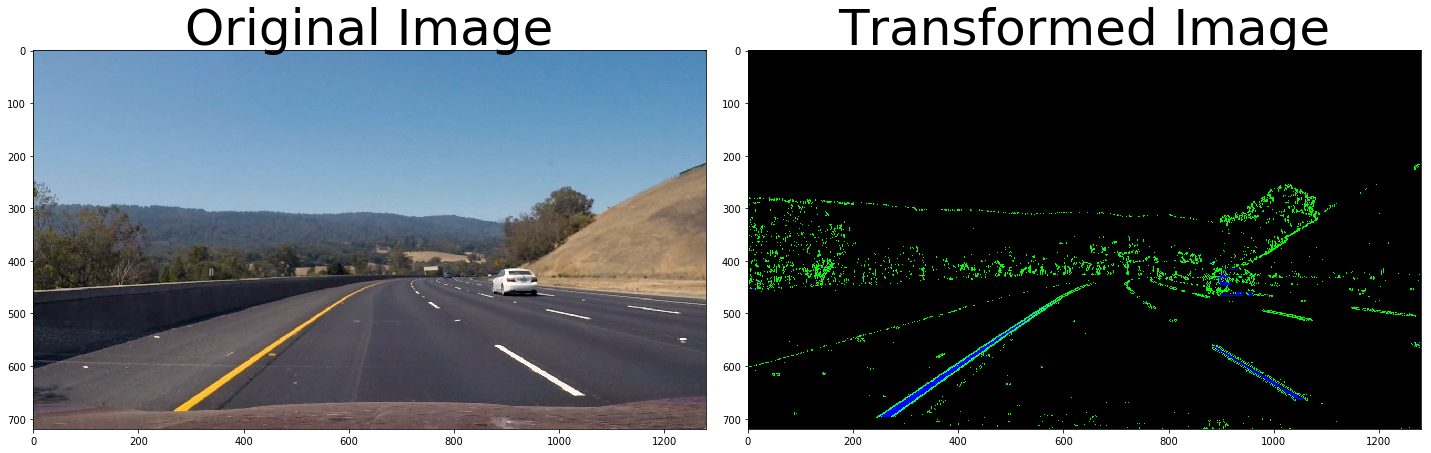

In [18]:
path = "test_images/"
testImageStrings = os.listdir(path)
for testImageString in testImageStrings:
    testImage = mpimg.imread(path + testImageString)
    undistortedTestImage = cv2.undistort(testImage, cameraMatrix, distortionCoefficients, None, cameraMatrix)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(testImage)
    ax1.set_title('Original Image', fontsize=50)
    gradient = pipeline(undistortedTestImage)
    ax2.imshow(gradient)
    ax2.set_title('Transformed Image', fontsize=50)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  